### Unweighted

In [84]:
import os

# Define the directory path
directory = r'F:\GitHub\KU-1\Variations\New Data\comp'

# Create an empty list to store the file paths
file_paths = []

# Loop through all the files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a .csv file
        if file.endswith('.csv'):
            # If it is, append its path (relative to the directory) to the csv_files list
            file_paths.append(os.path.join(root[len(directory)+1:], file))

# Add the directory path to each file path in the list
file_paths = [os.path.join('New Data', 'comp', file).replace('\\', '/') for file in file_paths]


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def calculate_average(file_paths, output_path):

    def read_and_interpolate(file_path, x_values):
        df = pd.read_csv(file_path)
        
        # Group data points by the same X-value and take the mean of their Y-values
        df = df.groupby('X', as_index=False).mean()
        
        min_x = df['X'].min()
        max_x = df['X'].max()
        x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
        f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
        y_values = np.empty_like(x_values)
        y_values[:] = np.nan
        y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
        return y_values

    # X values to interpolate to (logarithmically spaced from 20 Hz to 20 kHz)
    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    # Read and interpolate all .csv files
    data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

    def find_mean_in_range(data, x_min, x_max):
        indices = (x_values >= x_min) & (x_values <= x_max)
        return np.mean(data[indices])

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    # Calculate the mean values of each dataset in the alignment frequency range
    mean_values = [find_mean_in_range(data[i], *alignment_freq_range) for i in range(len(data))]

    # Calculate the target mean value as the average of the individual mean values
    target_mean = np.mean(mean_values)

    # Align datasets to the target mean value
    for i in range(len(data)):
        shift = target_mean - mean_values[i]
        data[i] += shift

    # Compute the final average of the aligned datasets
    average = np.mean(data, axis=0)

    # Save the average to a .csv file
    average_df = pd.DataFrame({'X': x_values, 'Y': average})
    average_df = average_df.dropna(subset=['Y'])  # Remove rows where Y is NaN
    average_df.to_csv(output_path, index=False)
    
    return x_values, average, data

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def interpolate_and_restore_nans(y_values, window):
    not_nan = ~np.isnan(y_values)
    indices = np.arange(len(y_values))
    interpolated_y_values = np.interp(indices, indices[not_nan], y_values[not_nan])
    
    # Use a smaller window size, for example, 21 instead of 51
    filtered_y_values = savgol_filter(interpolated_y_values, window, 3)
    
    filtered_y_values[~not_nan] = np.nan
    return filtered_y_values

def plot_data(x_values, average, data, title, color):
    
    plt.figure(figsize=(20, 10))
    for y_values in data:
        smoothed_y_values = interpolate_and_restore_nans(y_values, 21)  # Apply Savitzky-Golay filter
        plt.plot(x_values, smoothed_y_values, color='lightgray', linewidth=0.75)
    plt.ylim(30, 85)
    plt.xlim(20, 20000)
    plt.plot(x_values, average, color=color, linewidth=3, label='Average')
    plt.xscale('log')

    # Customize Y-axis
    plt.yticks(np.arange(30, 86, 5), fontsize=12)

    # Customize X-axis
    x_ticks = np.array([
        20, 30, 40, 50, 60, 80, 100, 150,
        200, 300, 400, 500, 600, 800,
        1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
        10000, 15000, 20000
    ])
    labels = [
        f'{int(x)}Hz' if x == 20
        else f'{int(x)}' if x < 1000
        else f'{x/1000:.1f}k' if x == 1500
        else f'{x//1000:.0f}k' if x != 20000
        else '20kHz' for x in x_ticks
    ]
    plt.xticks(x_ticks, labels=labels, fontsize=12)

    # Set labels and title
    plt.ylabel('dB', fontsize=12)
    plt.title(title, fontsize=20)

    # Subtitle
    plt.text(0.5, 0.95, f'{len(file_paths)} Measurements by:', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
    plt.text(0.5, 0.92, 'Aftersound, Banbeucmas, BryAudioReviews, CammyFi, Crinacle, Gizaudio, Harpo, Hawaii Bad Boy', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
    plt.text(0.5, 0.89, 'Hobby Talk, Moondrop, Neptone Audio, nymz, Precogvision, Sharur, Shortbus, Super* Review', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

    plt.text(0.95, 0.05, 'By Lesbian :3', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

    # Legend
    plt.legend()

    # Customize grid
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.show()

In [87]:
# Calculate the average using the list of file directories
x_values, average, data = calculate_average(file_paths, 'output/community_avg_xenns_top.csv')

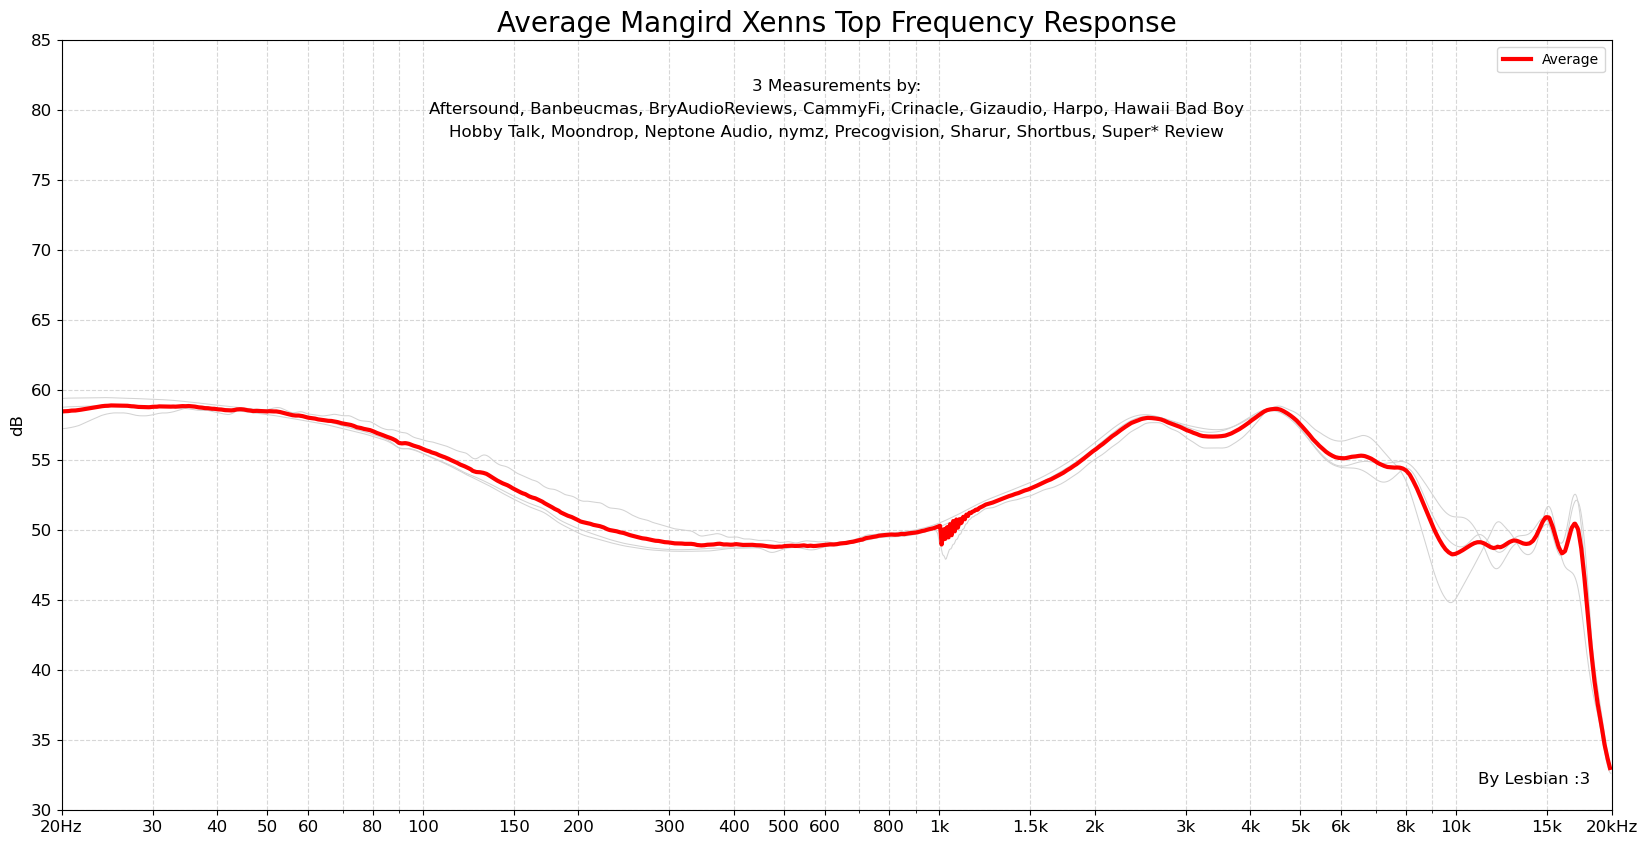

In [88]:
# Plot the data using the calculated average and original data
plot_data(x_values, average, data, 'Average Mangird Xenns Top Frequency Response', 'red')

### Weighted-Average

In [89]:
# All Measurement Sources
sources = [
    'aftersound', 'banbeucmas', 'bryaudioreviews', 'cammyfi', 'crinacle',
    'gizaudio', 'harpo', 'hawaiibadboy', 'hobbytalk', 'misc', 'moondrop',
    'neptoneaudio', 'nymz', 'precog', 'sharur', 'shortbus', 'super'
]

# Initialize source_file_paths dictionary with empty lists for each source
source_file_paths = {source: [] for source in sources}

# Iterate over the file paths and categorize them
for file_path in file_paths:
    # Extract the source name from the file path
    source_name = file_path.split('/')[2].split('_')[0].lower()
    
    # If the source name is in the list of sources, append the file path to the corresponding list
    if source_name in sources:
        source_file_paths[source_name].append(file_path)


In [90]:
# Print the measurements in the precog group for testing
#rint(source_file_paths['precog'])

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def create_average_from_csv_files(file_paths, output_path='output/'):

    def read_and_interpolate(file_path, x_values):
        df = pd.read_csv(file_path)
        min_x = df['X'].min()
        max_x = df['X'].max()
        x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
        f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
        y_values = np.empty_like(x_values)
        y_values[:] = np.nan
        y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
        return y_values

    def find_mean_in_range(data, x_min, x_max):
        indices = (x_values >= x_min) & (x_values <= x_max)
        return np.mean(data[indices])

    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    mean_values = [find_mean_in_range(data[i], *alignment_freq_range) for i in range(len(data))]

    target_mean = np.mean(mean_values)

    for i in range(len(data)):
        shift = target_mean - mean_values[i]
        data[i] += shift

    average = np.mean(data, axis=0)

    average_df = pd.DataFrame({'X': x_values, 'Y': average})
    average_df = average_df.dropna(subset=['Y'])  # Remove rows where Y is NaN
    average_df.to_csv(output_path, index=False)

for source in sources:
    create_average_from_csv_files(source_file_paths[source], output_path=f'output/source/average_{source}.csv')


c:\Users\Agnes\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Agnes\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Agnes\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Agnes\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Agnes\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Agnes\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\User

In [92]:
# Print the categorized file paths

#for source, file_paths in source_file_paths.items():
#    print(source)
#    for file_path in file_paths:
#        print(file_path)


In [93]:
import os

# Define the directory path
directory = r'F:\GitHub\KU-1\Variations\output\source'

# Create an empty list to store the file paths
weighted_file_paths = []

# Loop through all the files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a .csv file
        if file.endswith('.csv'):
            # If it is, append its path (relative to the directory) to the csv_files list
            weighted_file_paths.append(os.path.join(root[len(directory)+1:], file))

# Add the directory path to each file path in the list
weighted_file_paths = [os.path.join('output', 'Source', file).replace('\\', '/') for file in weighted_file_paths]


In [94]:
# Calculate the average using the list of file directories
weighted_x_values, weighted_average, weighted_data = calculate_average(weighted_file_paths, 'output/weighted_community_avg_variations.csv')

C:\Users\Agnes\AppData\Local\Temp\ipykernel_2276\2880056198.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('X', as_index=False).mean()


KeyError: 'Y'

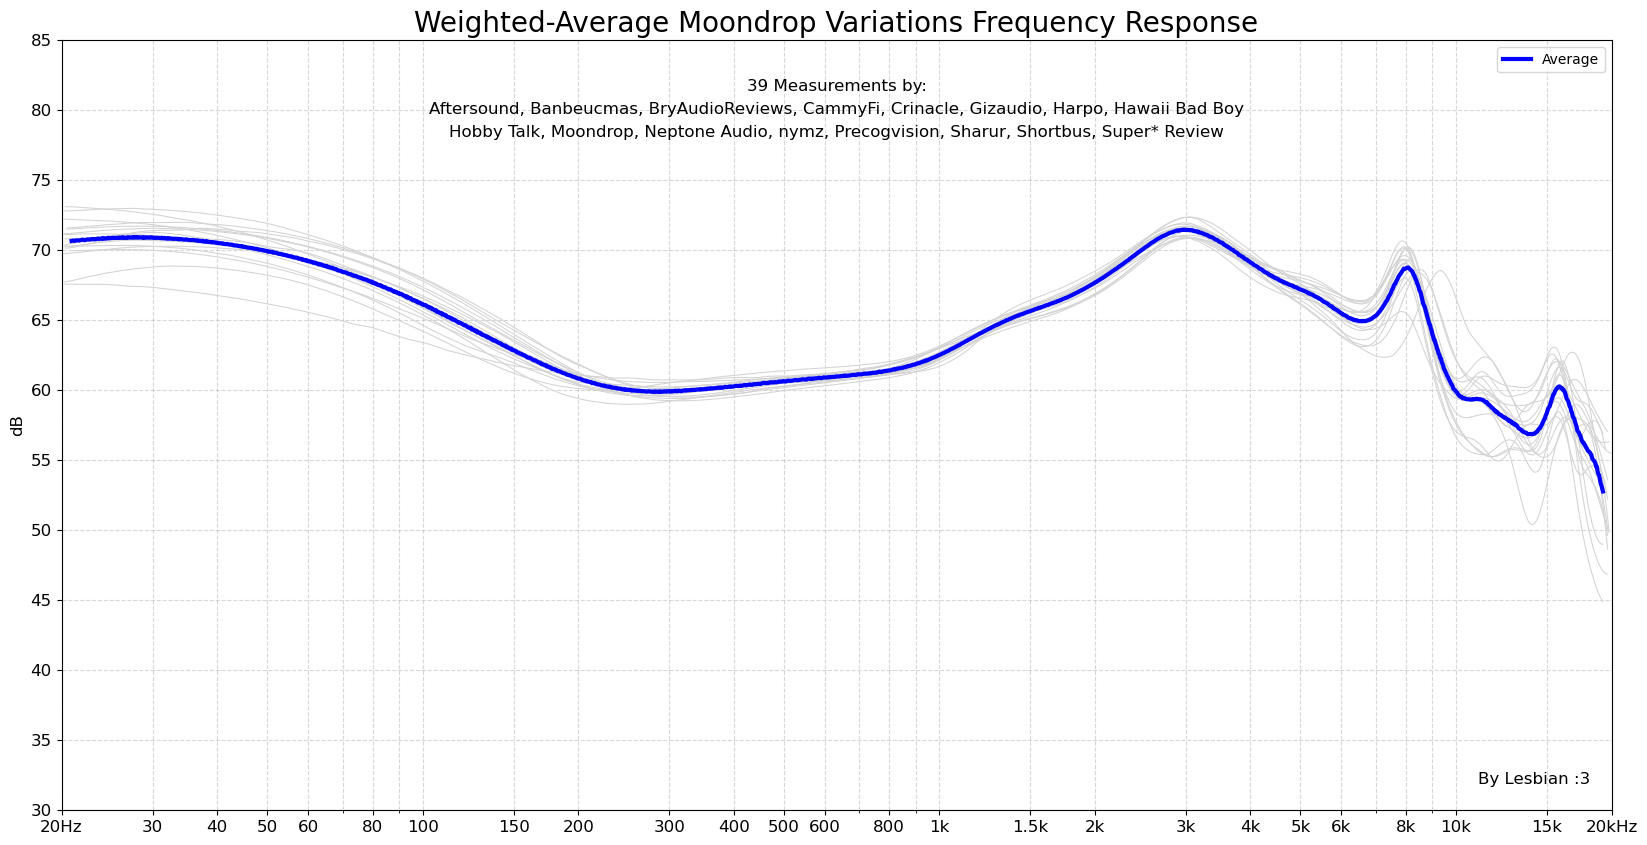

In [ ]:
# Plot the data using the calculated average and original data
plot_data(weighted_x_values, weighted_average, weighted_data, 'Weighted-Average Moondrop Variations Frequency Response', 'blue')

### Preference %

In [95]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def target_adherence(input_csv, target_csv):
    def read_and_interpolate(file_path, x_values):
        df = pd.read_csv(file_path)
        min_x = df['X'].min()
        max_x = df['X'].max()
        x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
        f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
        y_values = np.empty_like(x_values)
        y_values[:] = np.nan
        y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
        return y_values

    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    input_data = read_and_interpolate(input_csv, x_values)
    target_data = read_and_interpolate(target_csv, x_values)

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    def find_mean_in_range(data, x_min, x_max):
        indices = (x_values >= x_min) & (x_values <= x_max)
        return np.mean(data[indices])

    input_mean = find_mean_in_range(input_data, *alignment_freq_range)
    target_mean = find_mean_in_range(target_data, *alignment_freq_range)

    shift = target_mean - input_mean
    input_data += shift

    differences = np.abs(target_data - input_data)
    mean_difference = np.nanmean(differences)

    y_range = np.nanmax(target_data) - np.nanmin(target_data)

    adherence = 100 * (1 - mean_difference / y_range)

    return adherence

In [96]:
input_csv = 'output/community_avg_xenns_top.csv'
target_csv = 'Objectively Neutral IE Target.csv'
adherence_percentage = target_adherence(input_csv, target_csv)

print(f"Adherence: {adherence_percentage:.2f}%")

Adherence: 92.65%
